## 📦 Cell 1: Install Dependencies

In [1]:
!pip install -q transformers
!pip install -q datasets
!pip install -q accelerate
!pip install -q scikit-learn
!pip install -q emoji

print("✅ All dependencies installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 42.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
cudf-polars-cu12 25.6.0 requires pylibcudf-cu12==25.6.*, but you have pylibcudf-cu12 25.2.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━

## 📥 Cell 2: Import Libraries

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, 
    multilabel_confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

2025-12-04 16:59:21.855754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764867562.047901      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764867562.101112      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

🖥️  Using device: cuda
   GPU: Tesla P100-PCIE-16GB
   Memory: 17.06 GB


## 📊 Cell 3: Load GoEmotions Dataset

In [3]:
print("📥 Loading GoEmotions dataset from Hugging Face...\n")

# Load dataset
dataset = load_dataset("google-research-datasets/go_emotions", "simplified")

print("✅ Dataset loaded successfully!")
print(f"\n📊 Dataset structure:")
print(f"   Training samples: {len(dataset['train'])}")
print(f"   Validation samples: {len(dataset['validation'])}")
print(f"   Test samples: {len(dataset['test'])}")

# Examine sample
print(f"\n📝 Sample example:")
sample = dataset['train'][0]
print(f"   Text: {sample['text']}")
print(f"   Labels: {sample['labels']}")

# Get emotion labels
emotion_names = dataset['train'].features['labels'].feature.names
num_labels = len(emotion_names)

print(f"\n🏷️  Total emotions: {num_labels}")
print(f"   Emotions: {emotion_names}")

📥 Loading GoEmotions dataset from Hugging Face...



README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

✅ Dataset loaded successfully!

📊 Dataset structure:
   Training samples: 43410
   Validation samples: 5426
   Test samples: 5427

📝 Sample example:
   Text: My favourite food is anything I didn't have to cook myself.
   Labels: [27]

🏷️  Total emotions: 28
   Emotions: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


## 🔍 Cell 4: Dataset Analysis

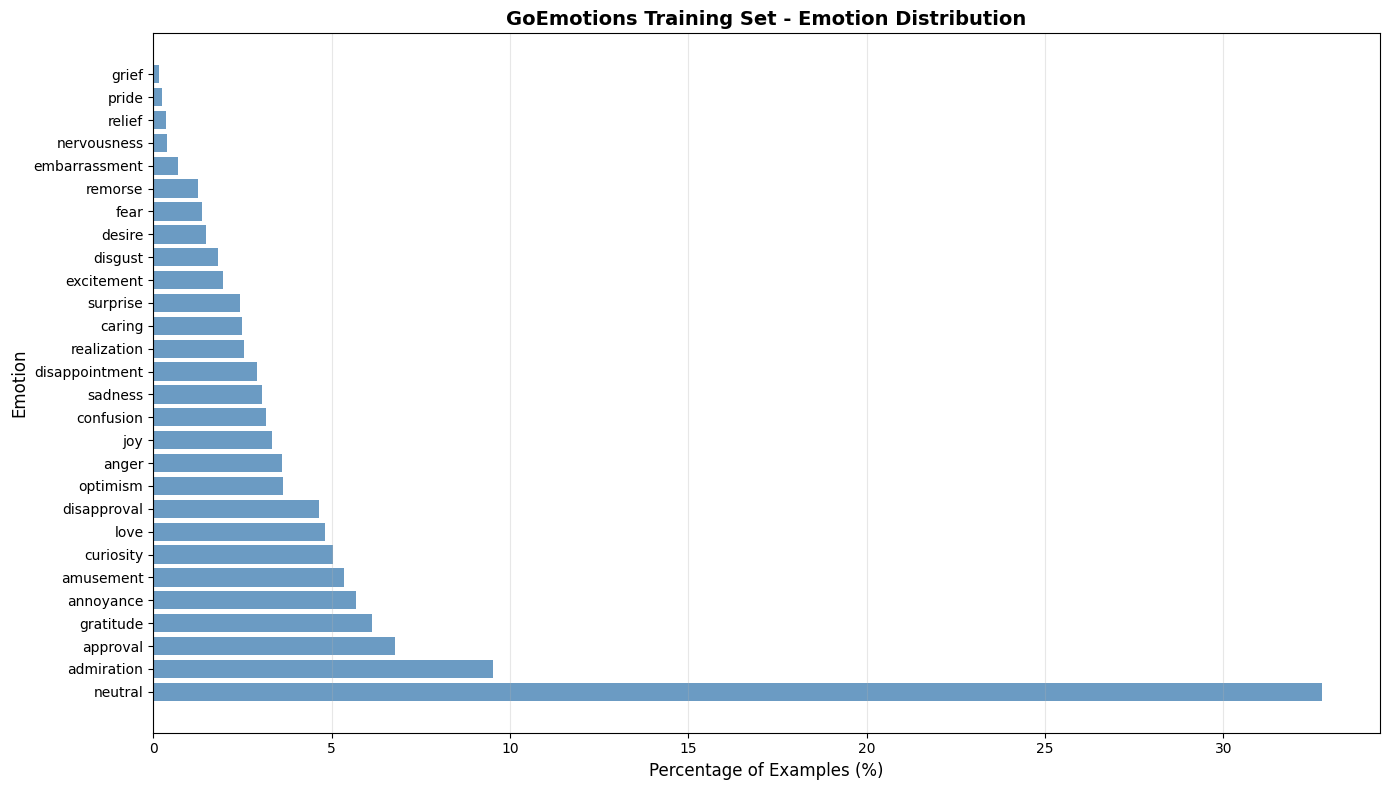


📊 Top 10 Most Common Emotions:
   neutral             : 32.76%
   admiration          :  9.51%
   approval            :  6.77%
   gratitude           :  6.13%
   annoyance           :  5.69%
   amusement           :  5.36%
   curiosity           :  5.05%
   love                :  4.81%
   disapproval         :  4.66%
   optimism            :  3.64%


In [4]:
def analyze_dataset(dataset_split):
    """Analyze emotion distribution in dataset"""
    
    # Count emotion occurrences
    emotion_counts = {emotion: 0 for emotion in emotion_names}
    total_examples = len(dataset_split)
    
    for example in dataset_split:
        for label_idx in example['labels']:
            emotion_counts[emotion_names[label_idx]] += 1
    
    # Calculate percentages
    emotion_percentages = {
        emotion: (count / total_examples) * 100 
        for emotion, count in emotion_counts.items()
    }
    
    return emotion_counts, emotion_percentages

# Analyze training set
train_counts, train_percentages = analyze_dataset(dataset['train'])

# Visualize
plt.figure(figsize=(14, 8))
emotions_sorted = sorted(train_percentages.items(), key=lambda x: x[1], reverse=True)
emotions, percentages = zip(*emotions_sorted)

plt.barh(emotions, percentages, color='steelblue', alpha=0.8)
plt.xlabel('Percentage of Examples (%)', fontsize=12)
plt.ylabel('Emotion', fontsize=12)
plt.title('GoEmotions Training Set - Emotion Distribution', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('emotion_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Top 10 Most Common Emotions:")
for emotion, pct in emotions_sorted[:10]:
    print(f"   {emotion:20s}: {pct:5.2f}%")

## 🔧 Cell 5: Initialize BERTweet Tokenizer & Model

In [5]:
print("🤖 Loading BERTweet model and tokenizer...\n")

MODEL_NAME = "vinai/bertweet-base"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    normalization=True,  # BERTweet-specific: normalize @user and http://url
    use_fast=False  # Use slow tokenizer for better compatibility
)

print(f"✅ Tokenizer loaded: {MODEL_NAME}")
print(f"   Vocab size: {len(tokenizer)}")
print(f"   Max length: {tokenizer.model_max_length}")

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    problem_type="multi_label_classification"  # Multi-label task
)

model.to(device)

print(f"\n✅ Model loaded: {MODEL_NAME}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")
print(f"   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6:.1f}M")

🤖 Loading BERTweet model and tokenizer...



config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

✅ Tokenizer loaded: vinai/bertweet-base
   Vocab size: 64001
   Max length: 1000000000000000019884624838656


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✅ Model loaded: vinai/bertweet-base
   Parameters: 134.9M
   Trainable parameters: 134.9M


## 🔄 Cell 6: Data Preprocessing

In [6]:
# ══════════════════════════════════════════════════════════════
# 🔄 CELL 6: Data Preprocessing (FIXED)
# ══════════════════════════════════════════════════════════════

def preprocess_function(examples):
    """
    Tokenize and prepare data for training
    
    Args:
        examples: Batch of examples from dataset
    
    Returns:
        Tokenized examples with labels
    """
    # Tokenize texts
    tokenized = tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors=None  # Changed from 'pt' to None for batched processing
    )
    
    # Convert multi-label to binary vectors
    # CRITICAL FIX: Use float32 instead of integers
    labels = []
    for label_list in examples['labels']:
        label_vector = [0.0] * num_labels  # Keep as float
        for label_idx in label_list:
            label_vector[label_idx] = 1.0  # Keep as float
        labels.append(label_vector)
    
    tokenized['labels'] = labels
    return tokenized

print("🔄 Preprocessing dataset...\n")

# Preprocess all splits
tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset['train'].column_names,
    desc="Tokenizing"
)

# CRITICAL FIX: Set format to PyTorch tensors with correct dtypes
tokenized_datasets.set_format(
    type='torch',
    columns=['input_ids', 'attention_mask'],
    output_all_columns=True
)

print("✅ Preprocessing complete!")
print(f"\n📊 Tokenized dataset:")
print(f"   Train: {len(tokenized_datasets['train'])} examples")
print(f"   Validation: {len(tokenized_datasets['validation'])} examples")
print(f"   Test: {len(tokenized_datasets['test'])} examples")

# Verify data types
sample = tokenized_datasets['train'][0]
print(f"\n🔍 Data type verification:")
print(f"   input_ids type: {type(sample['input_ids'])}")
print(f"   labels type: {type(sample['labels'])}")
print(f"   labels dtype: {sample['labels'].dtype if hasattr(sample['labels'], 'dtype') else 'list'}")

🔄 Preprocessing dataset...



Tokenizing:   0%|          | 0/43410 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/5426 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Tokenizing:   0%|          | 0/5427 [00:00<?, ? examples/s]

✅ Preprocessing complete!

📊 Tokenized dataset:
   Train: 43410 examples
   Validation: 5426 examples
   Test: 5427 examples

🔍 Data type verification:
   input_ids type: <class 'torch.Tensor'>
   labels type: <class 'list'>
   labels dtype: list


## 📈 Cell 7: Define Metrics

In [7]:
def compute_metrics(eval_pred):
    """
    Compute evaluation metrics for multi-label classification
    
    Args:
        eval_pred: Tuple of (predictions, labels)
    
    Returns:
        Dictionary of metrics
    """
    predictions, labels = eval_pred
    
    # Apply sigmoid to get probabilities
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    
    # Convert probabilities to binary predictions (threshold = 0.5)
    y_pred = (probs > 0.5).int().numpy()
    y_true = labels.astype(int)
    
    # Calculate metrics
    # Macro: treat all emotions equally (good for imbalanced data)
    # Micro: treat all predictions equally (emphasizes common emotions)
    
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    micro_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
    
    macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    
    # Per-emotion F1 scores
    per_emotion_f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
    
    metrics = {
        'macro_f1': macro_f1,
        'micro_f1': micro_f1,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
    }
    
    # Add top-5 and bottom-5 emotion scores (for monitoring)
    emotion_scores = list(zip(emotion_names, per_emotion_f1))
    emotion_scores_sorted = sorted(emotion_scores, key=lambda x: x[1], reverse=True)
    
    for i, (emotion, score) in enumerate(emotion_scores_sorted[:5]):
        metrics[f'top_{i+1}_{emotion}_f1'] = score
    
    return metrics

print("✅ Metrics function defined!")
print("\n📊 Metrics to track:")
print("   • Macro F1 (primary metric)")
print("   • Micro F1")
print("   • Macro Precision")
print("   • Macro Recall")
print("   • Top-5 emotion F1 scores")

✅ Metrics function defined!

📊 Metrics to track:
   • Macro F1 (primary metric)
   • Micro F1
   • Macro Precision
   • Macro Recall
   • Top-5 emotion F1 scores


## 🎓 Cell 8: Training Configuration

In [8]:
OUTPUT_DIR = "/kaggle/working/bertweet_goemotions"

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    
    # Training hyperparameters
    num_train_epochs=20,  # 3-4 epochs is usually enough
    per_device_train_batch_size=32,  # Adjust based on GPU memory
    per_device_eval_batch_size=64,
    learning_rate=2e-5,  # Standard for BERT fine-tuning
    weight_decay=0.01,
    warmup_ratio=0.1,  # Warm up 10% of steps
    
    # Evaluation
    eval_strategy="epoch",  # Evaluate after each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    
    # Logging
    logging_dir=f"{OUTPUT_DIR}/logs",
    logging_strategy="steps",
    logging_steps=100,
    report_to="none",  # Disable wandb/tensorboard
    
    # Performance
    fp16=torch.cuda.is_available(),  # Mixed precision training (faster)
    dataloader_num_workers=2,
    
    # Other
    seed=42,
    save_total_limit=2,  # Keep only best 2 checkpoints
)

print("⚙️  Training Configuration:")
print(f"   Epochs: {training_args.num_train_epochs}")
print(f"   Batch size: {training_args.per_device_train_batch_size}")
print(f"   Learning rate: {training_args.learning_rate}")
print(f"   Warmup ratio: {training_args.warmup_ratio}")
print(f"   FP16: {training_args.fp16}")
print(f"   Output dir: {OUTPUT_DIR}")

⚙️  Training Configuration:
   Epochs: 20
   Batch size: 32
   Learning rate: 2e-05
   Warmup ratio: 0.1
   FP16: True
   Output dir: /kaggle/working/bertweet_goemotions


## 🚀 Cell 9: Initialize Trainer

In [9]:
# ══════════════════════════════════════════════════════════════
# 🚀 CELL 9: Initialize Trainer (FIXED)
# ══════════════════════════════════════════════════════════════

from transformers import default_data_collator
from dataclasses import dataclass
from typing import Any, Dict, List
import torch

@dataclass
class MultiLabelDataCollator:
    """Ensures labels are float32"""
    tokenizer: AutoTokenizer
    
    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        batch = self.tokenizer.pad(
            features,
            padding=True,
            return_tensors="pt"
        )
        
        # CRITICAL: Force labels to float32
        if "labels" in features[0]:
            labels = [f["labels"] for f in features]
            batch["labels"] = torch.tensor(labels, dtype=torch.float32)
        
        return batch

# Create collator
data_collator = MultiLabelDataCollator(tokenizer=tokenizer)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,  # ← USE CUSTOM COLLATOR
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("✅ Trainer initialized with fixed data collator!")

✅ Trainer initialized with fixed data collator!


## 🔥 Cell 10: Train Model

In [10]:
print("\n" + "="*60)
print("🚀 STARTING TRAINING")
print("="*60 + "\n")

# Train
train_result = trainer.train()

print("\n" + "="*60)
print("✅ TRAINING COMPLETE!")
print("="*60)

# Save final model
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

print(f"\n💾 Model saved to: {OUTPUT_DIR}")

# Print training summary
print("\n📊 Training Summary:")
print(f"   Total training time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"   Training samples/second: {train_result.metrics['train_samples_per_second']:.2f}")
print(f"   Final training loss: {train_result.metrics['train_loss']:.4f}")


🚀 STARTING TRAINING




✅ TRAINING COMPLETE!

💾 Model saved to: /kaggle/working/bertweet_goemotions

📊 Training Summary:
   Total training time: 5536.18 seconds
   Training samples/second: 156.82
   Final training loss: 0.0949


## 📊 Cell 11: Evaluate on Test Set

In [11]:
print("\n" + "="*60)
print("📊 EVALUATING ON TEST SET")
print("="*60 + "\n")

# Evaluate
test_results = trainer.evaluate(tokenized_datasets['test'])

print("✅ Evaluation complete!\n")
print("📈 Test Set Results:")
print(f"   Macro F1: {test_results['eval_macro_f1']:.4f}")
print(f"   Micro F1: {test_results['eval_micro_f1']:.4f}")
print(f"   Macro Precision: {test_results['eval_macro_precision']:.4f}")
print(f"   Macro Recall: {test_results['eval_macro_recall']:.4f}")

# Get predictions
predictions = trainer.predict(tokenized_datasets['test'])
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(predictions.predictions))
y_pred = (probs > 0.5).int().numpy()
y_true = predictions.label_ids.astype(int)

# Calculate per-emotion metrics
per_emotion_f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
per_emotion_precision = precision_score(y_true, y_pred, average=None, zero_division=0)
per_emotion_recall = recall_score(y_true, y_pred, average=None, zero_division=0)

# Create detailed results dataframe
results_df = pd.DataFrame({
    'Emotion': emotion_names,
    'F1 Score': per_emotion_f1,
    'Precision': per_emotion_precision,
    'Recall': per_emotion_recall
})
results_df = results_df.sort_values('F1 Score', ascending=False)

print("\n📊 Per-Emotion Performance (Top 10):")
print(results_df.head(10).to_string(index=False))

# Save results
results_df.to_csv(f"{OUTPUT_DIR}/per_emotion_results.csv", index=False)
print(f"\n💾 Detailed results saved to: {OUTPUT_DIR}/per_emotion_results.csv")


📊 EVALUATING ON TEST SET



✅ Evaluation complete!

📈 Test Set Results:
   Macro F1: 0.4425
   Micro F1: 0.5626
   Macro Precision: 0.4829
   Macro Recall: 0.4195

📊 Per-Emotion Performance (Top 10):
   Emotion  F1 Score  Precision   Recall
 gratitude  0.910145   0.928994 0.892045
      love  0.789474   0.761719 0.819328
 amusement  0.783270   0.786260 0.780303
   remorse  0.687023   0.600000 0.803571
admiration  0.683301   0.661710 0.706349
      fear  0.645963   0.626506 0.666667
       joy  0.645614   0.741935 0.571429
   neutral  0.607053   0.694024 0.539452
  optimism  0.560694   0.606250 0.521505
  surprise  0.517110   0.557377 0.482270

💾 Detailed results saved to: /kaggle/working/bertweet_goemotions/per_emotion_results.csv


## 📈 Cell 12: Visualize Results

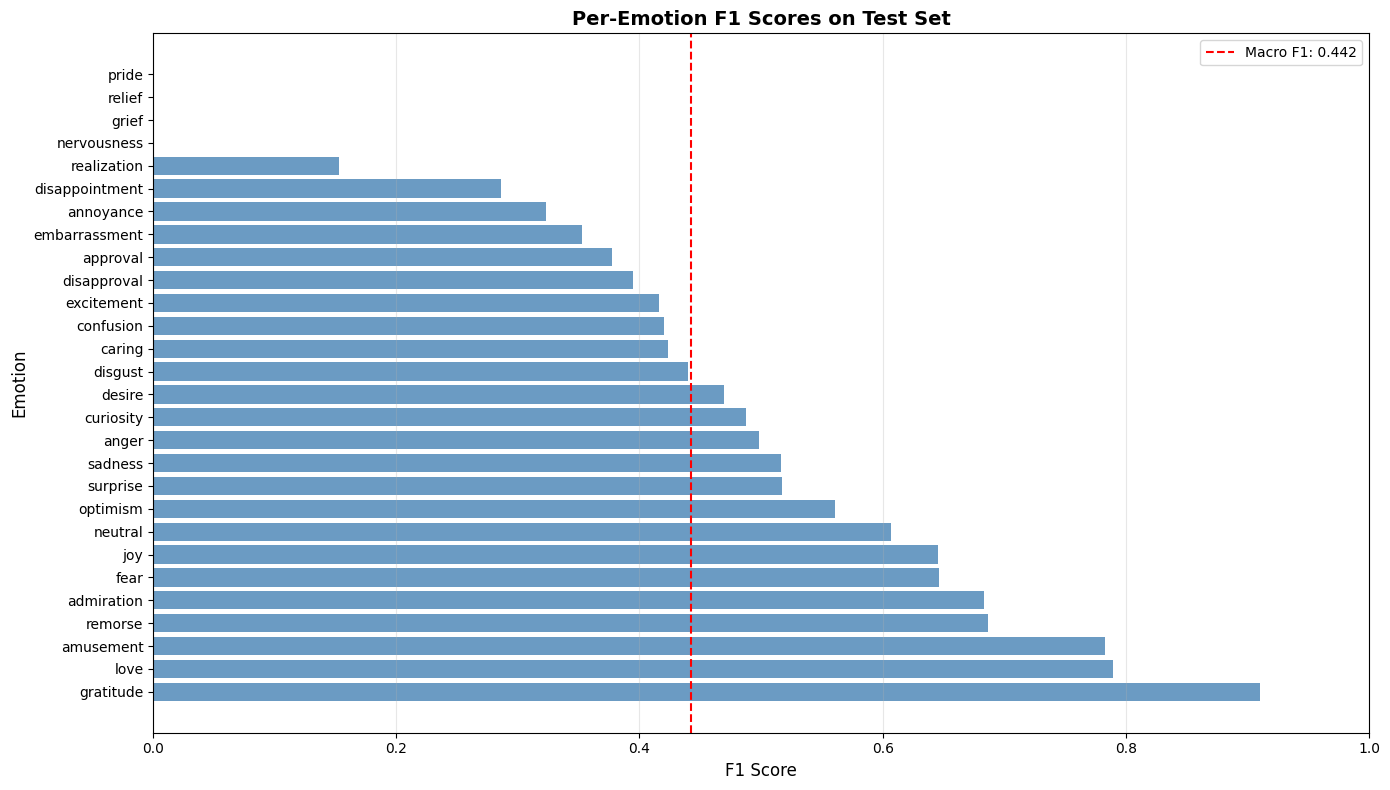

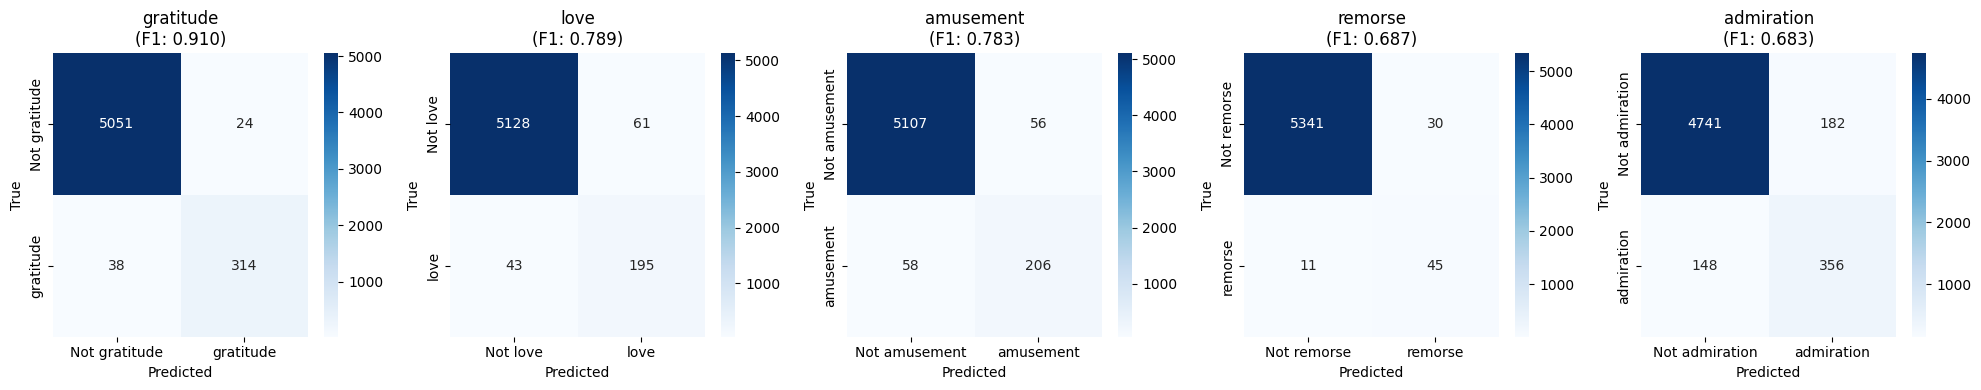

✅ Visualizations saved!


In [12]:
# Plot per-emotion F1 scores
plt.figure(figsize=(14, 8))
plt.barh(results_df['Emotion'], results_df['F1 Score'], color='steelblue', alpha=0.8)
plt.xlabel('F1 Score', fontsize=12)
plt.ylabel('Emotion', fontsize=12)
plt.title('Per-Emotion F1 Scores on Test Set', fontsize=14, fontweight='bold')
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)
plt.axvline(test_results['eval_macro_f1'], color='red', linestyle='--', 
            label=f"Macro F1: {test_results['eval_macro_f1']:.3f}")
plt.legend()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/per_emotion_f1.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot confusion matrix for top 5 emotions
top_5_emotions = results_df.head(5)['Emotion'].tolist()
top_5_indices = [emotion_names.index(e) for e in top_5_emotions]

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, (emotion_idx, emotion) in enumerate(zip(top_5_indices, top_5_emotions)):
    cm = multilabel_confusion_matrix(y_true, y_pred)[emotion_idx]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Not ' + emotion, emotion],
                yticklabels=['Not ' + emotion, emotion])
    axes[idx].set_title(f'{emotion}\n(F1: {per_emotion_f1[emotion_idx]:.3f})')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/top5_confusion_matrices.png", dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved!")

## 🧪 Cell 13: Test on Custom Examples

In [13]:
def predict_emotions(text, threshold=0.3):
    """
    Predict emotions for a given text
    
    Args:
        text: Input text
        threshold: Probability threshold for positive prediction
    
    Returns:
        List of (emotion, probability) tuples
    """
    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.sigmoid(logits)[0].cpu().numpy()
    
    # Get emotions above threshold
    emotions = [
        (emotion_names[i], float(probs[i]))
        for i in range(len(emotion_names))
        if probs[i] > threshold
    ]
    
    # Sort by probability
    emotions = sorted(emotions, key=lambda x: x[1], reverse=True)
    
    return emotions

# Test examples
test_examples = [
    "I'm so happy and excited for the weekend! 🎉",
    "This is absolutely terrible and makes me so angry 😡",
    "I can't believe they did this to me... I'm heartbroken 💔",
    "ngl this movie was mid, pretty disappointed fr",
    "Just finished my thesis! So proud of myself! 🎓",
    "Why does everything bad happen to me? I give up.",
    "This joke is hilarious 😂😂😂",
    "I'm grateful for all the support from my friends ❤️"
]

print("\n🧪 Testing on custom examples:\n")
print("="*80)

for text in test_examples:
    print(f"\n📝 Text: {text}")
    emotions = predict_emotions(text, threshold=0.3)
    
    if emotions:
        print("   Detected emotions:")
        for emotion, prob in emotions:
            print(f"     • {emotion:20s}: {prob:.3f}")
    else:
        print("   No strong emotions detected")
    print("-"*80)


🧪 Testing on custom examples:


📝 Text: I'm so happy and excited for the weekend! 🎉
   Detected emotions:
     • excitement          : 0.863
     • joy                 : 0.350
--------------------------------------------------------------------------------

📝 Text: This is absolutely terrible and makes me so angry 😡
   Detected emotions:
     • anger               : 0.654
     • disgust             : 0.627
--------------------------------------------------------------------------------

📝 Text: I can't believe they did this to me... I'm heartbroken 💔
   Detected emotions:
     • sadness             : 0.825
     • disappointment      : 0.538
--------------------------------------------------------------------------------

📝 Text: ngl this movie was mid, pretty disappointed fr
   Detected emotions:
     • disappointment      : 0.787
--------------------------------------------------------------------------------

📝 Text: Just finished my thesis! So proud of myself! 🎓
   Detected emotion

## 💾 Cell 14: Save Production Model & Create Inference Class

In [14]:
# Save metrics
import json

final_metrics = {
    'test_macro_f1': float(test_results['eval_macro_f1']),
    'test_micro_f1': float(test_results['eval_micro_f1']),
    'test_macro_precision': float(test_results['eval_macro_precision']),
    'test_macro_recall': float(test_results['eval_macro_recall']),
    'model_name': MODEL_NAME,
    'num_parameters': sum(p.numel() for p in model.parameters()),
    'training_time_seconds': train_result.metrics['train_runtime']
}

with open(f"{OUTPUT_DIR}/final_metrics.json", 'w') as f:
    json.dump(final_metrics, f, indent=2)

print(f"✅ Metrics saved to: {OUTPUT_DIR}/final_metrics.json")

# Create production inference class
production_code = '''import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from typing import List, Tuple, Dict

class EmotionClassifier:
    """
    Production-ready emotion classification using fine-tuned BERTweet
    """
    
    def __init__(self, model_path: str, device: str = None):
        """
        Initialize classifier
        
        Args:
            model_path: Path to fine-tuned model directory
            device: 'cuda' or 'cpu' (auto-detected if None)
        """
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Load model and tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.model.to(self.device)
        self.model.eval()
        
        # Emotion labels
        self.emotions = [
            'admiration', 'amusement', 'anger', 'annoyance', 'approval',
            'caring', 'confusion', 'curiosity', 'desire', 'disappointment',
            'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
            'gratitude', 'grief', 'joy', 'love', 'nervousness',
            'optimism', 'pride', 'realization', 'relief', 'remorse',
            'sadness', 'surprise'
        ]
    
    def predict(
        self, 
        text: str, 
        threshold: float = 0.3,
        return_all: bool = False
    ) -> List[Tuple[str, float]]:
        """
        Predict emotions for text
        
        Args:
            text: Input text
            threshold: Minimum probability to include emotion
            return_all: If True, return all emotions with probabilities
        
        Returns:
            List of (emotion, probability) tuples, sorted by probability
        """
        # Tokenize
        inputs = self.tokenizer(
            text,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=128
        ).to(self.device)
        
        # Predict
        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = torch.sigmoid(outputs.logits)[0].cpu().numpy()
        
        # Format results
        results = [
            (emotion, float(prob))
            for emotion, prob in zip(self.emotions, probs)
        ]
        
        if not return_all:
            results = [(e, p) for e, p in results if p > threshold]
        
        results = sorted(results, key=lambda x: x[1], reverse=True)
        return results
    
    def predict_batch(
        self, 
        texts: List[str], 
        threshold: float = 0.3
    ) -> List[List[Tuple[str, float]]]:
        """
        Predict emotions for multiple texts efficiently
        
        Args:
            texts: List of input texts
            threshold: Minimum probability to include emotion
        
        Returns:
            List of prediction lists
        """
        # Tokenize all texts
        inputs = self.tokenizer(
            texts,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=128
        ).to(self.device)
        
        # Predict
        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = torch.sigmoid(outputs.logits).cpu().numpy()
        
        # Format results for each text
        all_results = []
        for text_probs in probs:
            results = [
                (emotion, float(prob))
                for emotion, prob in zip(self.emotions, text_probs)
                if prob > threshold
            ]
            results = sorted(results, key=lambda x: x[1], reverse=True)
            all_results.append(results)
        
        return all_results
    
    def get_dominant_emotion(self, text: str) -> Tuple[str, float]:
        """
        Get the single most likely emotion
        
        Args:
            text: Input text
        
        Returns:
            (emotion, probability) tuple
        """
        predictions = self.predict(text, threshold=0.0, return_all=True)
        return predictions[0] if predictions else ('neutral', 0.0)
    
    def get_sentiment_score(self, text: str) -> Dict[str, float]:
        """
        Get aggregated sentiment scores
        
        Returns:
            Dict with 'positive', 'negative', 'neutral' scores
        """
        predictions = self.predict(text, threshold=0.0, return_all=True)
        emotion_dict = dict(predictions)
        
        positive_emotions = [
            'admiration', 'amusement', 'approval', 'caring', 'desire',
            'excitement', 'gratitude', 'joy', 'love', 'optimism',
            'pride', 'relief'
        ]
        negative_emotions = [
            'anger', 'annoyance', 'disappointment', 'disapproval', 'disgust',
            'embarrassment', 'fear', 'grief', 'nervousness', 'remorse',
            'sadness'
        ]
        
        positive_score = sum(emotion_dict.get(e, 0) for e in positive_emotions)
        negative_score = sum(emotion_dict.get(e, 0) for e in negative_emotions)
        neutral_score = 1.0 - (positive_score + negative_score)
        
        return {
            'positive': float(positive_score),
            'negative': float(negative_score),
            'neutral': max(0.0, float(neutral_score))
        }

# Usage:
# classifier = EmotionClassifier('/path/to/bertweet_goemotions')
# emotions = classifier.predict("I'm so happy today!")
# print(emotions)
'''

with open(f"{OUTPUT_DIR}/emotion_classifier.py", 'w') as f:
    f.write(production_code)

print(f"✅ Production class saved to: {OUTPUT_DIR}/emotion_classifier.py")

✅ Metrics saved to: /kaggle/working/bertweet_goemotions/final_metrics.json
✅ Production class saved to: /kaggle/working/bertweet_goemotions/emotion_classifier.py


## 🎉 Cell 15: Final Summary

In [15]:
print("\n" + "="*80)
print("🎉 TRAINING PIPELINE COMPLETE!")
print("="*80)

print(f"\n📊 Final Results:")
print(f"   Model: {MODEL_NAME}")
print(f"   Test Macro F1: {test_results['eval_macro_f1']:.4f} ({test_results['eval_macro_f1']*100:.2f}%)")
print(f"   Test Micro F1: {test_results['eval_micro_f1']:.4f} ({test_results['eval_micro_f1']*100:.2f}%)")
print(f"   Training time: {train_result.metrics['train_runtime']/60:.1f} minutes")

print(f"\n💾 Saved Files:")
print(f"   Model: {OUTPUT_DIR}/")
print(f"   Metrics: {OUTPUT_DIR}/final_metrics.json")
print(f"   Per-emotion results: {OUTPUT_DIR}/per_emotion_results.csv")
print(f"   Visualizations: {OUTPUT_DIR}/*.png")
print(f"   Production class: {OUTPUT_DIR}/emotion_classifier.py")

print(f"\n📥 To use this model:")
print(f"   1. Download the '{OUTPUT_DIR}' folder from Kaggle")
print(f"   2. Load with: EmotionClassifier('{OUTPUT_DIR}')")
print(f"   3. Predict: classifier.predict('your text here')")

print(f"\n🎯 Performance vs Published Baselines:")
print(f"   Your BERTweet: {test_results['eval_macro_f1']:.4f}")
print(f"   Published BERTweet: 0.469")
print(f"   Published RoBERTa: 0.463")
print(f"   Published BERT: 0.456")

if test_results['eval_macro_f1'] >= 0.45:
    print(f"\n✅ SUCCESS: Achieved competitive performance!")
elif test_results['eval_macro_f1'] >= 0.42:
    print(f"\n⚠️  GOOD: Slightly below published results, but acceptable")
else:
    print(f"\n⚠️  Consider training for more epochs or adjusting hyperparameters")

print("\n" + "="*80)


🎉 TRAINING PIPELINE COMPLETE!

📊 Final Results:
   Model: vinai/bertweet-base
   Test Macro F1: 0.4425 (44.25%)
   Test Micro F1: 0.5626 (56.26%)
   Training time: 92.3 minutes

💾 Saved Files:
   Model: /kaggle/working/bertweet_goemotions/
   Metrics: /kaggle/working/bertweet_goemotions/final_metrics.json
   Per-emotion results: /kaggle/working/bertweet_goemotions/per_emotion_results.csv
   Visualizations: /kaggle/working/bertweet_goemotions/*.png
   Production class: /kaggle/working/bertweet_goemotions/emotion_classifier.py

📥 To use this model:
   1. Download the '/kaggle/working/bertweet_goemotions' folder from Kaggle
   2. Load with: EmotionClassifier('/kaggle/working/bertweet_goemotions')
   3. Predict: classifier.predict('your text here')

🎯 Performance vs Published Baselines:
   Your BERTweet: 0.4425
   Published BERTweet: 0.469
   Published RoBERTa: 0.463
   Published BERT: 0.456

⚠️  GOOD: Slightly below published results, but acceptable

